In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import matplotlib.pyplot as plt
import os
import glob
import time

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aayush9753/image-colorization-dataset")

print("Path to dataset files:", path)

100%|██████████| 473M/473M [00:06<00:00, 76.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aayush9753/image-colorization-dataset/versions/1


In [7]:
train_paths = '/root/.cache/kagglehub/datasets/aayush9753/image-colorization-dataset/versions/1/data/train_color'
train_images = glob.glob(os.path.join(train_paths, "**", "*.jpg"), recursive=True)

In [8]:
print(f"Gambar berwarna siap training: {len(train_images)}")

Gambar berwarna siap training: 5000


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
LR = 2e-4
EPOCHS = 50

# --- 1. DATASET CLASS ---
class LabDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # Load gambar RGB
        img = Image.open(self.paths[idx]).convert("RGB")

        # Resize & Transform
        if self.transform:
          img = self.transform(img)

        img = np.array(img)

        # Konversi ke LAB
        img_lab = rgb2lab(img).astype("float32")

        # Normalisasi
        # L: [0, 100] -> [0, 1]
        # ab: [-128, 127] -> [-1, 1]
        img_l = img_lab[:, :, 0] / 100.0
        img_ab = img_lab[:, :, 1:] / 128.0

        # To Tensor
        img_l_t = torch.from_numpy(img_l).unsqueeze(0) # (1, H, W)
        img_ab_t = torch.from_numpy(img_ab.transpose((2, 0, 1))) # (2, H, W)

        return img_l_t, img_ab_t

# Resize ke 256x256
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
])

# Load Dataset
full_dataset = LabDataset(train_images, transform=transform)
dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [11]:
# --- 2. MODEL ARSITEKTUR (ResNet U-Net) ---
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()

        # Encoder: ResNet18 Pretrained
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder
        self.decoder4 = self._block(512, 256)
        self.decoder3 = self._block(256 + 256, 128)
        self.decoder2 = self._block(128 + 128, 64)
        self.decoder1 = self._block(64 + 64, 32)

        self.final = nn.Conv2d(32, 2, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, 1, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)

        d4 = self.decoder4(e5)
        d3 = self.decoder3(torch.cat([d4, e4], dim=1))
        d2 = self.decoder2(torch.cat([d3, e3], dim=1))
        d1 = self.decoder1(torch.cat([d2, e2], dim=1))

        out = self.final(d1)
        out = self.upsample(out)

        return out

model = ColorizationNet().to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [ ]:
# --- 3. TRAINING LOOP ---
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"Mulai training untuk {len(train_images)} gambar...")
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (input_l, target_ab) in enumerate(dataloader):
        input_l = input_l.to(device)
        target_ab = target_ab.to(device)

        outputs = model(input_l)
        loss = criterion(outputs, target_ab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print setiap 50 batch biar tau progress
        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(dataloader)
    print(f"=== Epoch {epoch+1} Selesai. Avg Loss: {avg_loss:.4f} ===")

torch.save(model.state_dict(), 'model_colorization_tuned.pth')

Mulai training untuk 5000 gambar...
Epoch [1/50], Step [50/157], Loss: 0.0900
Epoch [1/50], Step [100/157], Loss: 0.0656
Epoch [1/50], Step [150/157], Loss: 0.0679
=== Epoch 1 Selesai. Avg Loss: 0.0870 ===
Epoch [2/50], Step [50/157], Loss: 0.0655
Epoch [2/50], Step [100/157], Loss: 0.0771
Epoch [2/50], Step [150/157], Loss: 0.0615
=== Epoch 2 Selesai. Avg Loss: 0.0711 ===
Epoch [3/50], Step [50/157], Loss: 0.0631
Epoch [3/50], Step [100/157], Loss: 0.0724
Epoch [3/50], Step [150/157], Loss: 0.0673
=== Epoch 3 Selesai. Avg Loss: 0.0694 ===
Epoch [4/50], Step [50/157], Loss: 0.0685
Epoch [4/50], Step [100/157], Loss: 0.0709
Epoch [4/50], Step [150/157], Loss: 0.0719
=== Epoch 4 Selesai. Avg Loss: 0.0681 ===
Epoch [5/50], Step [50/157], Loss: 0.0749
Epoch [5/50], Step [100/157], Loss: 0.0590
Epoch [5/50], Step [150/157], Loss: 0.0631
=== Epoch 5 Selesai. Avg Loss: 0.0669 ===
Epoch [6/50], Step [50/157], Loss: 0.0655
Epoch [6/50], Step [100/157], Loss: 0.0539
Epoch [6/50], Step [150/157],

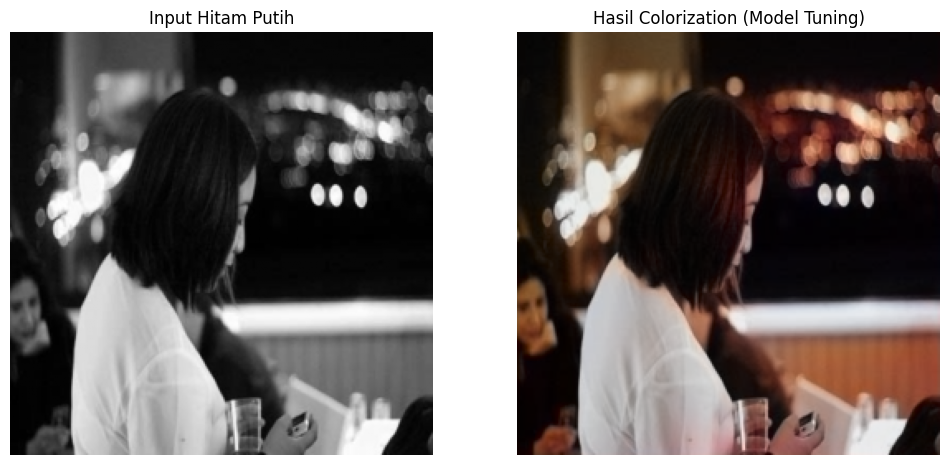

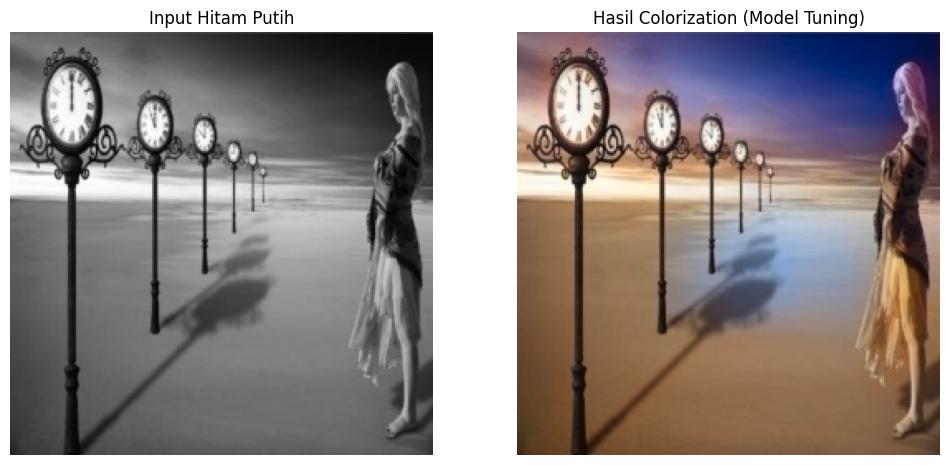

In [ ]:
def show_result(idx=0):
    model.eval()
    img_path = train_images[idx] # Ambil gambar ke-idx dari dataset

    img = Image.open(img_path).convert("RGB")
    img = transform(img)
    img_arr = np.array(img)

    img_lab = rgb2lab(img_arr).astype("float32")
    img_l = img_lab[:, :, 0] / 100.0

    with torch.no_grad():
        input_l = torch.from_numpy(img_l).unsqueeze(0).unsqueeze(0).to(device)
        pred_ab = model(input_l)

    pred_ab = pred_ab.squeeze().cpu().numpy().transpose((1, 2, 0)) * 128.0

    # Gabung L asli dengan ab Prediksi
    result_lab = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    result_lab[:, :, 0] = img_lab[:, :, 0] # Pakai L asli
    result_lab[:, :, 1:] = pred_ab

    result_rgb = lab2rgb(result_lab)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb2gray(img_arr), cmap='gray')
    plt.title("Input Hitam Putih")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_rgb)
    plt.title("Hasil Colorization (Model Tuning)")
    plt.axis('off')
    plt.show()

show_result(459)
show_result(890)

# Evaluation

In [12]:
model.load_state_dict(torch.load("model_colorization_tuned (2).pth", map_location=device))
model.eval()

ColorizationNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [13]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [14]:
def evaluate_image(model, gray_path, gt_color_path, device="cuda"):

    # Load grayscale & ground truth color image
    gt_color = np.array(Image.open(gt_color_path).convert("RGB"))
    gray_img = np.array(Image.open(gray_path).convert("RGB"))

    # Resize
    gt_resized = np.array(Image.fromarray(gt_color).resize((256, 256)))
    gray_resized = np.array(Image.fromarray(gray_img).resize((256, 256)))

    # Convert grayscale
    from skimage.color import rgb2lab, lab2rgb
    lab = rgb2lab(gray_resized)
    L = lab[:, :, 0] / 100.0

    # Inference
    input_l = torch.tensor(L).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred_ab = model(input_l).cpu().numpy()[0].transpose(1,2,0)

    pred_ab = pred_ab * 128

    # Build reconstructed LAB
    lab_pred = np.zeros((256, 256, 3))
    lab_pred[:,:,0] = lab[:, :, 0]
    lab_pred[:,:,1:] = pred_ab

    pred_rgb = lab2rgb(lab_pred)
    pred_rgb = (pred_rgb * 255).astype("uint8")

    psnr = peak_signal_noise_ratio(gt_resized, pred_rgb)
    ssim = structural_similarity(gt_resized, pred_rgb, channel_axis=2)

    return psnr, ssim, pred_rgb

In [32]:
test_color_paths = '/root/.cache/kagglehub/datasets/aayush9753/image-colorization-dataset/versions/1/data/test_color'
test_color_images = glob.glob(os.path.join(test_color_paths, "**", "*.jpg"), recursive=True)

test_bnw_paths = '/root/.cache/kagglehub/datasets/aayush9753/image-colorization-dataset/versions/1/data/test_black'
test_bnw_images = glob.glob(os.path.join(test_bnw_paths, "**", "*.jpg"), recursive=True)

test_color_images = sorted(test_color_images)
test_bnw_images = sorted(test_bnw_images)

In [33]:
results = []

for gray_path, gt_path in zip(test_bnw_images, test_color_images):
    psnr, ssim, pred_rgb = evaluate_image(model, gray_path, gt_path, device=device)
    results.append((gray_path, psnr, ssim))

/tmp/ipython-input-1244256522.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(lab_pred)
/tmp/ipython-input-1244256522.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(lab_pred)
/tmp/ipython-input-1244256522.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(lab_pred)
/tmp/ipython-input-1244256522.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(lab_pred)


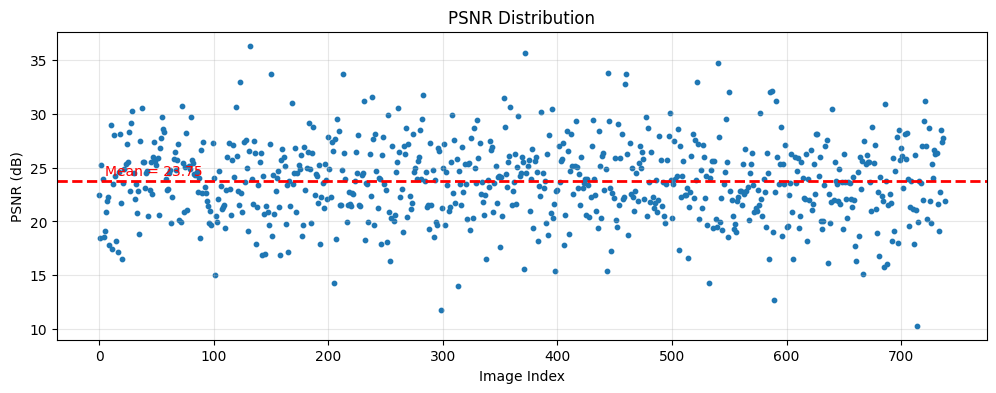

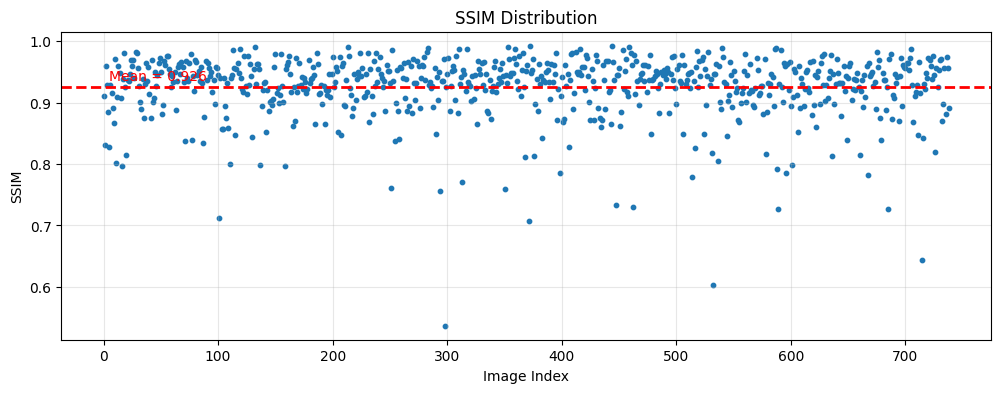

In [34]:
import matplotlib.pyplot as plt

image_names = [os.path.basename(r[0]) for r in results]
psnr_scores = [r[1] for r in results]
ssim_scores = [r[2] for r in results]

plt.figure(figsize=(12,4))
plt.scatter(range(len(psnr_scores)), psnr_scores, s=10)
plt.title("PSNR Distribution")
plt.xlabel("Image Index")
plt.ylabel("PSNR (dB)")
plt.grid(alpha=0.3)

plt.axhline(np.mean(psnr_scores), color='red', linestyle='--', linewidth=2)
plt.text(5, np.mean(psnr_scores)+0.5, f"Mean = {np.mean(psnr_scores):.2f}", color='red')

plt.show()

plt.figure(figsize=(12,4))
plt.scatter(range(len(ssim_scores)), ssim_scores, s=10)
plt.title("SSIM Distribution")
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.grid(alpha=0.3)

plt.axhline(np.mean(ssim_scores), color='red', linestyle='--', linewidth=2)
plt.text(5, np.mean(ssim_scores)+0.01, f"Mean = {np.mean(ssim_scores):.3f}", color='red')

plt.show()

In [35]:
def show_result(gray_path, gt_path, pred_rgb):
    gray = np.array(Image.open(gray_path).convert("RGB"))
    gt = np.array(Image.open(gt_path).convert("RGB"))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(gray)
    plt.title("Input B&W")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(pred_rgb)
    plt.title("Predicted Color")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(gt)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.show()

/tmp/ipython-input-1244256522.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(lab_pred)


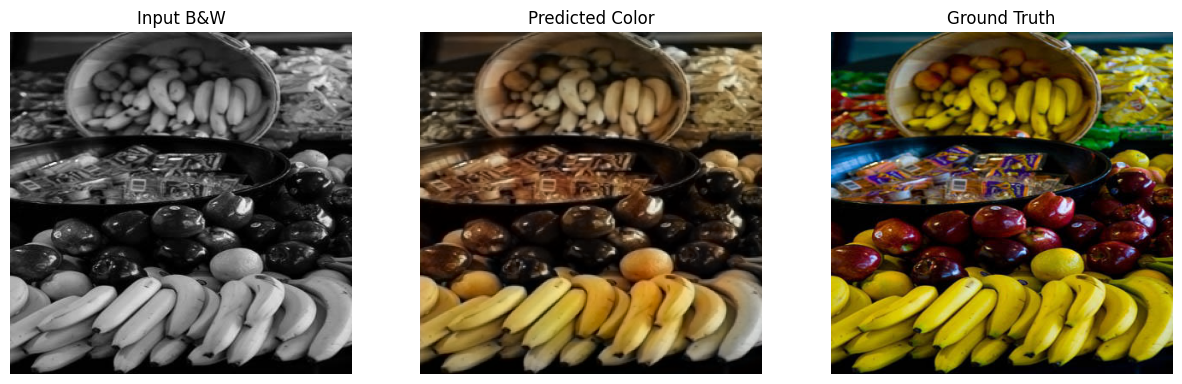

In [43]:
psnr, ssim, pred_rgb = evaluate_image(model, test_bnw_images[462], test_color_images[462], device=device)
show_result(test_bnw_images[462], test_color_images[462], pred_rgb)